In [1]:
%load_ext autoreload

In [2]:
%autoreload

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np 
import pandas as pd 
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
import seaborn as sns 
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("ticks")
import math

sns.set_style('darkgrid')

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import sklearn as skl
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [3]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

list_directory_tree_with_os_walk('.')

Directory: .
  File: Cleaning.ipynb
  File: Forecasting A.ipynb
  File: Forecasting B.ipynb
  File: Forecasting C.ipynb
  File: full_arimax_A.csv
  File: full_arimax_B.csv
  File: full_arimax_C.csv
  File: full_arimax_test_213_0.csv
  File: Getting csv.ipynb
  File: Neg_Pow_Inc_0.csv
  File: Test File.ipynb
Directory: .\data
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: test.csv
Directory: .\data\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\data\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\data\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\Plots
  File: 1 pv_measurement.png
  File: absolute_humidity_2mgm3.png
  File: air_density_2mkgm3.png
  File: ceiling_he

In [16]:
train_b = pd.read_parquet('data/B/train_targets.parquet')

X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet').drop("date_calc", axis=1)

X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')

X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet').drop("date_calc", axis=1)

train_b_observed_part = train_b[train_b["time"] <= X_train_estimated_b["date_forecast"].min()]
train_b_estimated_part = train_b[train_b["time"] >= X_train_estimated_b["date_forecast"].min()].reset_index(drop = True)

train_b_estimated_part = pd.concat([train_b_estimated_part, pd.DataFrame([['2023-05-01 00:00:00',0]], columns=train_b.columns)], ignore_index=True)
train_b_estimated_part["time"] = train_b_estimated_part["time"].astype("datetime64[us]")

X_train_observed_b_clean = pd.DataFrame(columns=X_train_observed_b.columns)
for i in range(len(train_b_observed_part)-1):
    mean_values_observed = np.array(X_train_observed_b[(X_train_observed_b["date_forecast"] >= train_b_observed_part["time"][i]) & (X_train_observed_b["date_forecast"] <= train_b_observed_part["time"][i+1])].mean())
    mean_values_observed[0] = train_b_observed_part["time"][i]
    X_train_observed_b_clean = pd.concat([X_train_observed_b_clean, pd.DataFrame([mean_values_observed], columns=X_train_observed_b.columns)], ignore_index=True)
    # print(i)
X_train_observed_b_clean["date_forecast"] = X_train_observed_b_clean["date_forecast"].astype("datetime64[us]")

X_train_estimated_b_clean = pd.DataFrame(columns=X_train_estimated_b.columns)
for i in range(len(train_b_estimated_part)-1):
    mean_values_estimated = np.array(X_train_estimated_b[(X_train_estimated_b["date_forecast"] >= train_b_estimated_part["time"][i]) & (X_train_estimated_b["date_forecast"] <= train_b_estimated_part["time"][i+1])].mean())
    mean_values_estimated[0] = train_b_estimated_part["time"][i]
    X_train_estimated_b_clean = pd.concat([X_train_estimated_b_clean, pd.DataFrame([mean_values_estimated], columns=X_train_estimated_b.columns)], ignore_index=True)
    # print(i)
X_train_estimated_b_clean["date_forecast"] = X_train_estimated_b_clean["date_forecast"].astype("datetime64[us]")

X_train_b_clean = pd.concat([X_train_observed_b_clean, X_train_estimated_b_clean], ignore_index=True)

test_b_dates = pd.DataFrame(columns=train_b.columns).drop(["pv_measurement"],axis=1)
for i in range(len(X_test_estimated_b)):
    if (i%4 == 0):
        test_b_dates = pd.concat([test_b_dates, pd.DataFrame([X_test_estimated_b["date_forecast"][i]], columns=test_b_dates.columns)], ignore_index=True)
test_b_dates = pd.concat([test_b_dates, pd.DataFrame(['2023-07-04 00:00:00'], columns=test_b_dates.columns)], ignore_index=True)
test_b_dates["time"] = test_b_dates["time"].astype("datetime64[us]")

X_test_estimated_b_clean = pd.DataFrame(columns=X_test_estimated_b.columns)
for i in range(len(test_b_dates)-1):
    mean_values_test = np.array(X_test_estimated_b[(X_test_estimated_b["date_forecast"] >= test_b_dates["time"][i]) & (X_test_estimated_b["date_forecast"] <= test_b_dates["time"][i+1])].mean())
    mean_values_test[0] = test_b_dates["time"][i]
    X_test_estimated_b_clean = pd.concat([X_test_estimated_b_clean, pd.DataFrame([mean_values_test], columns=X_test_estimated_b.columns)], ignore_index=True)
    # print(i)

X_train_b_cleaner = X_train_b_clean[~((X_train_b_clean["date_forecast"].dt.year == 2023) & (X_train_b_clean["date_forecast"].dt.month == 1) & (X_train_b_clean["date_forecast"].dt.day == 26))]
train_b_clean = train_b[~((X_train_b_clean["date_forecast"].dt.year == 2023) & (X_train_b_clean["date_forecast"].dt.month == 1) & (X_train_b_clean["date_forecast"].dt.day == 26))]

X_train_b_cleaner = X_train_b_cleaner.drop(train_b_clean[train_b_clean.isna().any(axis=1)].index)
train_b_clean = train_b_clean.drop(train_b_clean[train_b_clean.isna().any(axis=1)].index)

X_train_b_cleanest = X_train_b_cleaner.drop(["ceiling_height_agl:m", "cloud_base_agl:m", "snow_density:kgm3"], axis=1)
X_train_b_cleanest["date_forecast"] = X_train_b_cleanest["date_forecast"].astype("datetime64[us]")

X_test_b_cleanest = X_test_estimated_b_clean.drop(["ceiling_height_agl:m", "cloud_base_agl:m", "snow_density:kgm3"], axis=1)
X_test_b_cleanest["date_forecast"] = X_test_b_cleanest["date_forecast"].astype("datetime64[us]")

In [5]:
for i in range(10):
    for j in range(10):
        for k in range(10):
            print(i, j, k, SARIMAX(train_b_clean["pv_measurement"], exog = X_train_b_cleanest.iloc[:,1:], order = (i, j, k)).fit().aic)

KeyboardInterrupt: 

In [ ]:
full_model_SARIMAX_b_2_1_9 = SARIMAX(train_b_clean["pv_measurement"], exog = X_train_b_cleanest.iloc[:,1:], order = (1, 0, 0))
full_model_SARIMAX_b_2_1_9_fit = full_model_SARIMAX_b_2_1_9.fit()
full_model_SARIMAX_b_2_1_9_fit_predicted = full_model_SARIMAX_b_2_1_9_fit.predict(start=len(X_train_b_cleanest), end=(len(X_train_b_cleanest) + len(X_test_b_cleanest)-1), type = "levels", exog = X_test_b_cleanest.iloc[:,1:])
full_model_SARIMAX_b_2_1_9_fit_predicted[full_model_SARIMAX_b_2_1_9_fit_predicted < 0] = 0
full_model_SARIMAX_b_2_1_9_fit_predicted_full = pd.DataFrame({'time': X_test_b_cleanest["date_forecast"], 'pv_measurement': full_model_SARIMAX_b_2_1_9_fit_predicted.reset_index(drop=True)}, columns=train_b_clean.columns)
full_model_SARIMAX_b_2_1_9_fit_train_predicted_full = pd.concat([train_b_clean, full_model_SARIMAX_b_2_1_9_fit_predicted_full], ignore_index=True)

C:\Users\olara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\olara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\olara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
full_model_SARIMAX_b = SARIMAX(train_b_clean["pv_measurement"], exog = X_train_b_cleanest.iloc[:,1:], order = (6, 0, 0))
full_model_SARIMAX_b_fit = full_model_SARIMAX_b.fit()
full_model_SARIMAX_b_fit_predicted = full_model_SARIMAX_b_fit.predict(start=len(X_train_b_cleanest), end=(len(X_train_b_cleanest) + len(X_test_b_cleanest)-1), type = "levels", exog = X_test_b_cleanest.iloc[:,1:])
full_model_SARIMAX_b_fit_predicted[full_model_SARIMAX_b_fit_predicted < 0] = 0
full_model_SARIMAX_b_fit_predicted_full = pd.DataFrame({'time': X_test_b_cleanest["date_forecast"], 'pv_measurement': full_model_SARIMAX_b_fit_predicted.reset_index(drop=True)}, columns=train_b_clean.columns)
full_model_SARIMAX_b_fit_train_predicted_full = pd.concat([train_b_clean, full_model_SARIMAX_b_fit_predicted_full], ignore_index=True)

C:\Users\olara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\olara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\olara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
print(full_model_SARIMAX_b_2_1_9_fit.aic)
print(full_model_SARIMAX_b_fit.aic)

355091.3641504952
354967.1684838012


In [ ]:
full_model_SARIMAX_b_fit_predicted_csv = pd.DataFrame({'id': np.arange(720,720*2), 'prediction': full_model_SARIMAX_b_fit_predicted.reset_index(drop=True)}, columns=["id", "prediction"])
full_model_SARIMAX_b_fit_predicted_csv.to_csv("full_arimax_B.csv", index=False)

In [ ]:
full_model_SARIMAX_b_fit_predicted_full.to_csv("full_arimax_B.csv", sep='\t')


In [ ]:
full_model_SARIMAX_b_fit_predicted_full

,time,pv_measurement
0,2023-05-01 00:00:00,1.667697
1,2023-05-01 01:00:00,2.575890
2,2023-05-01 02:00:00,1.317044
3,2023-05-01 03:00:00,3.251962
4,2023-05-01 04:00:00,47.451318
...,...,...
715,2023-07-03 19:00:00,0.000000
716,2023-07-03 20:00:00,0.000000
717,2023-07-03 21:00:00,0.000000
718,2023-07-03 22:00:00,0.000000


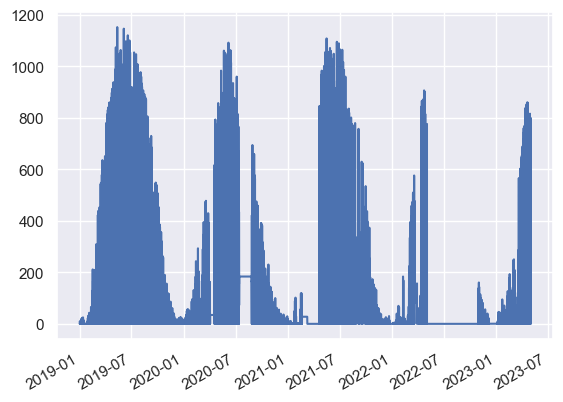

In [ ]:
plt.plot(train_b_clean.iloc[:,[0]], train_b_clean.iloc[:,[1]])
plt.gcf().autofmt_xdate()
plt.show()

In [18]:
full_model_SARIMAX_b = SARIMAX(train_b_clean["pv_measurement"], exog = X_train_b_cleanest.iloc[:,1:], order = (2, 1, 3))
full_model_SARIMAX_b_fit = full_model_SARIMAX_b.fit()
full_model_SARIMAX_b_fit_predicted = full_model_SARIMAX_b_fit.predict(start=len(X_train_b_cleanest), end=(len(X_train_b_cleanest) + len(X_test_b_cleanest)-1), type = "levels", exog = X_test_b_cleanest.iloc[:,1:])

MissingDataError: exog contains inf or nans

In [17]:
X_test_b_cleanest.iloc[:,1:]

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,4.300000,1.28300,0.000000,0.000000,0.0,271.649994,0.000000,0.000000,0.000000,0.000000,75.000000,7.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.775024,0.0,0.0,1000.424988,1006.675049,0.0,0.0,80.250000,1012.975037,0.0,0.0,0.0,0.0,16.027250,-10.54025,0.000,273.799988,75.000000,31107.601562,3.950,2.100,3.375,0.0
1,4.250000,1.28300,0.000000,0.000000,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.500000,7.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.250000,0.0,0.0,999.924988,1006.175049,0.0,0.0,79.800003,1012.475037,0.0,0.0,0.0,0.0,30.497749,-7.89400,0.000,273.799988,77.500000,30409.699219,3.825,1.925,3.300,0.0
2,4.150000,1.28275,0.000000,0.000000,0.0,271.050018,0.000000,0.000000,0.000000,0.000000,88.099998,7.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.699951,0.0,0.0,999.399963,1005.650024,0.0,0.0,78.000000,1011.950012,0.0,0.0,0.0,0.0,44.517750,-3.81500,0.000,273.850006,88.099998,31342.648438,3.650,1.750,3.225,0.0
3,4.025000,1.28225,10127.549805,11.675000,0.0,270.649994,9.375000,16845.576172,2.100000,3756.625000,68.775002,7.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1012.175049,0.0,0.0,998.849976,1005.099976,0.0,0.0,75.599998,1011.399963,0.0,0.0,0.0,0.0,58.083248,1.41300,0.000,273.899994,68.775002,34475.523438,3.500,1.475,3.150,0.0
4,3.900000,1.28200,141764.281250,76.900002,0.0,270.375000,47.400002,102203.046875,25.450001,49501.546875,66.349998,7.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1011.650024,0.0,0.0,998.349976,1004.650024,0.0,0.0,74.224998,1010.950012,0.0,0.0,0.0,0.0,71.341248,7.46900,0.000,273.924988,66.349998,35069.074219,3.325,1.300,3.075,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,8.350000,1.19800,477090.250000,85.099998,0.0,281.575012,33.625000,168752.750000,13.425000,50896.972656,85.599998,7.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,992.049988,0.0,0.0,979.474976,985.324951,0.0,0.0,69.250000,991.199951,0.0,0.0,0.0,0.0,306.687500,8.15300,0.100,287.024994,86.149994,43617.250000,2.475,2.075,-1.350,0.0
716,8.525000,1.20075,184337.953125,24.799999,0.0,281.850006,14.350000,86309.945312,3.550000,30550.300781,74.599998,7.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,992.549988,0.0,0.0,979.900024,985.775024,0.0,0.0,72.900002,991.674988,0.0,0.0,0.0,0.0,319.704742,3.26825,0.000,286.600006,75.325005,43830.601562,2.450,2.100,-1.275,0.0
717,8.799999,1.20375,37432.199219,1.275000,0.0,282.300018,1.300000,28167.427734,0.000000,6413.475098,76.125000,7.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,992.924988,0.0,0.0,980.250000,986.150024,0.0,0.0,77.949997,992.049988,0.0,0.0,0.0,0.0,333.040253,-0.44300,0.000,286.100006,76.850006,43401.023438,2.575,2.150,-1.400,0.0
718,9.000000,1.20600,360.125000,0.000000,0.0,282.675018,0.000000,2353.475098,0.000000,0.000000,98.199997,7.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,993.250000,0.0,0.0,980.575012,986.474976,0.0,0.0,81.650002,992.400024,0.0,0.0,0.0,0.0,346.686768,-2.75025,0.075,285.550018,98.324997,40885.898438,2.250,1.800,-1.350,0.0


In [7]:
full_model_SARIMAX_b_fit_predicted[full_model_SARIMAX_b_fit_predicted < 0] = 0

In [9]:
train_b_clean["pv_measurement"]

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
32843    0.828587
32844   -0.000000
32845   -0.000000
32846   -0.000000
32847   -0.000000
Name: pv_measurement, Length: 32820, dtype: float64

In [10]:
full_model_SARIMAX_b_fit_predicted

32820     1.667697
32821     2.575890
32822     1.317044
32823     3.251962
32824    47.451318
           ...    
33535     0.000000
33536     0.000000
33537     0.000000
33538     0.000000
33539     0.000000
Name: predicted_mean, Length: 720, dtype: float64

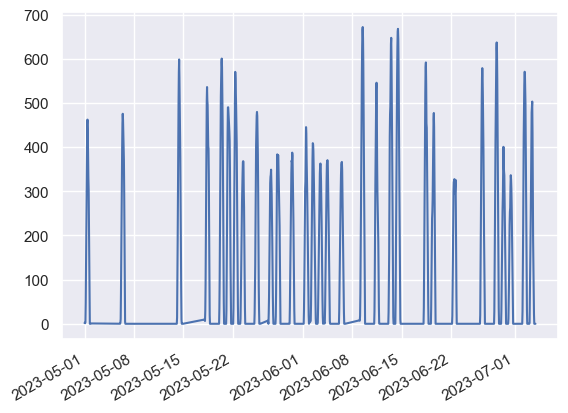

In [11]:
plt.plot(X_test_b_cleanest["date_forecast"],full_model_SARIMAX_b_fit_predicted)
plt.gcf().autofmt_xdate()
plt.show()

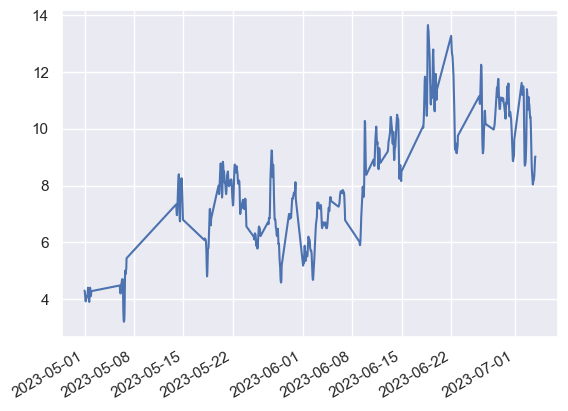

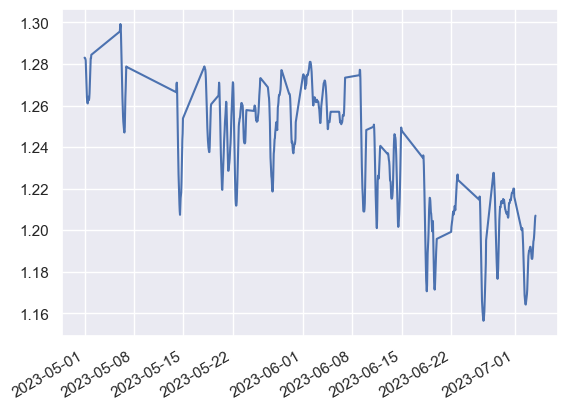

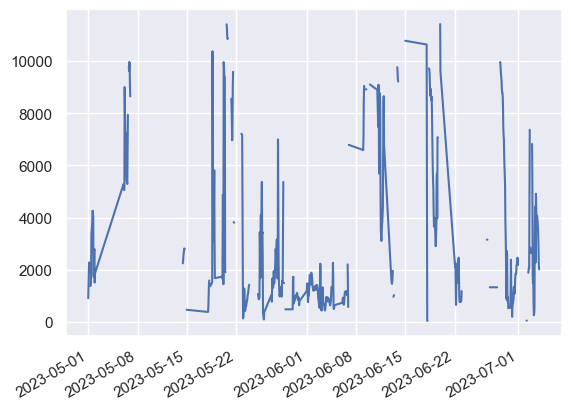

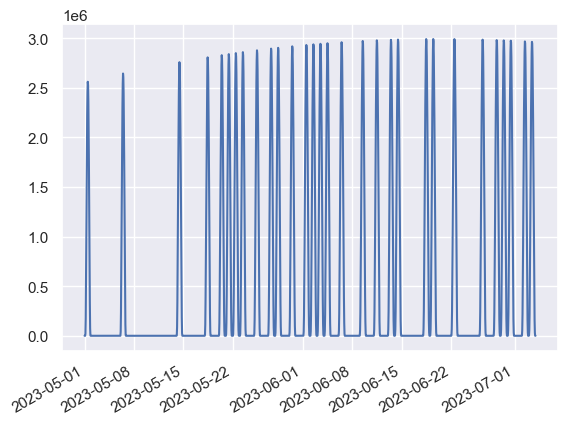

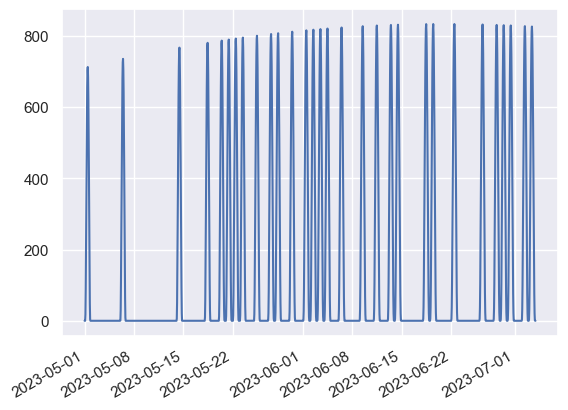

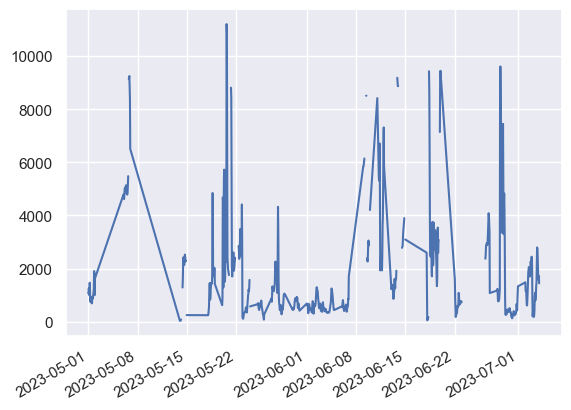

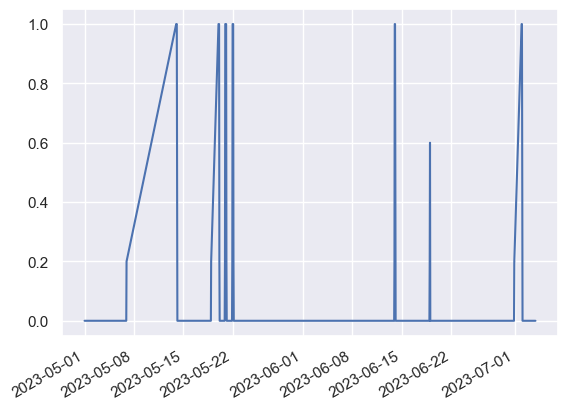

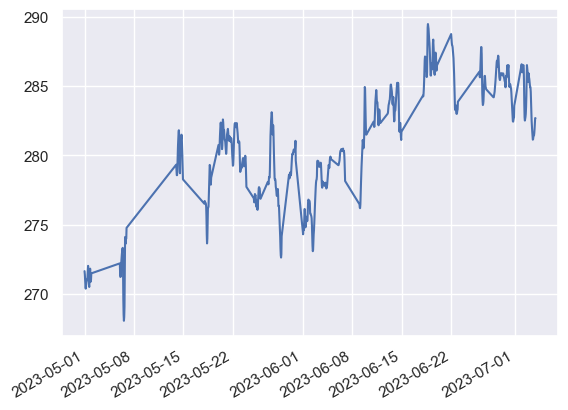

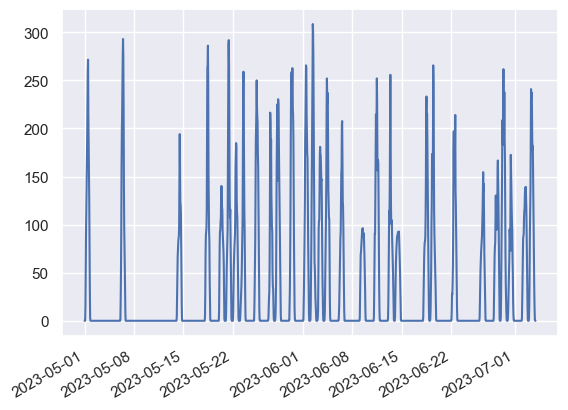

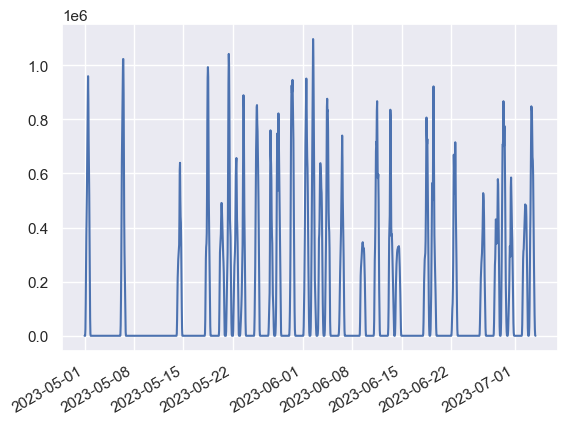

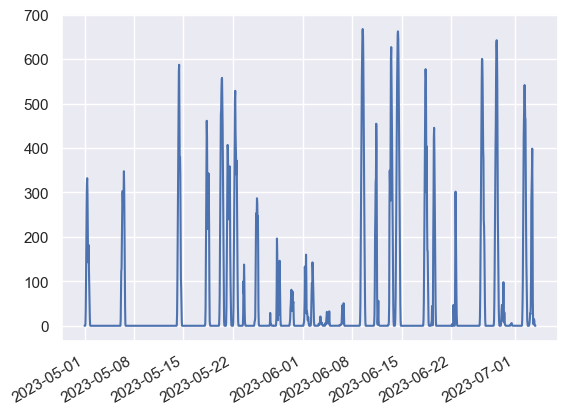

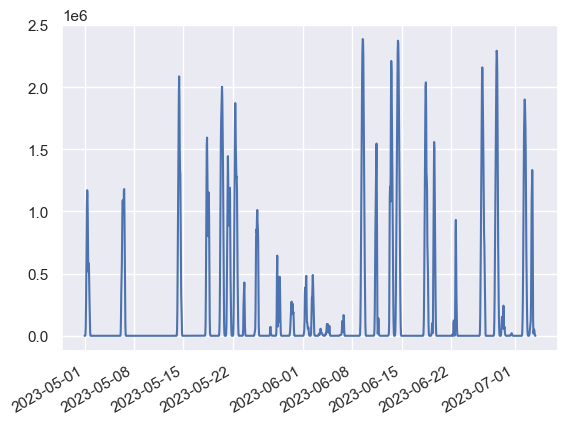

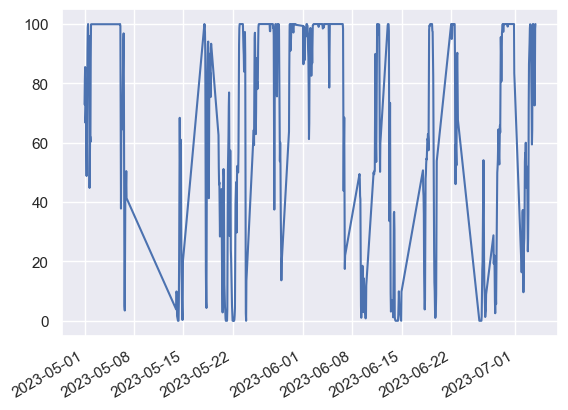

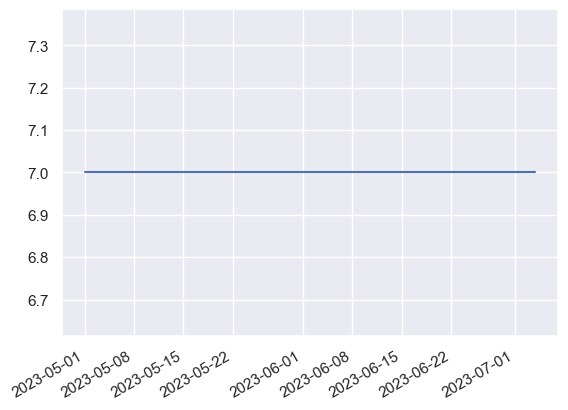

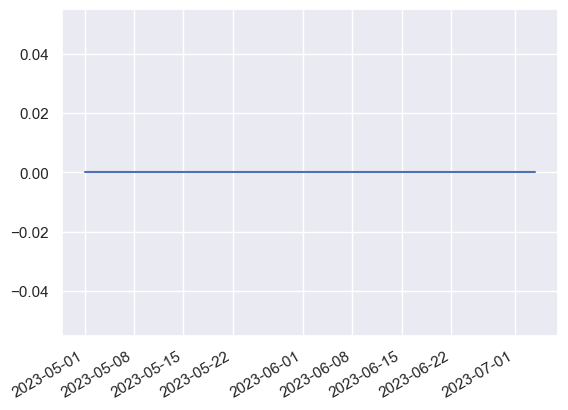

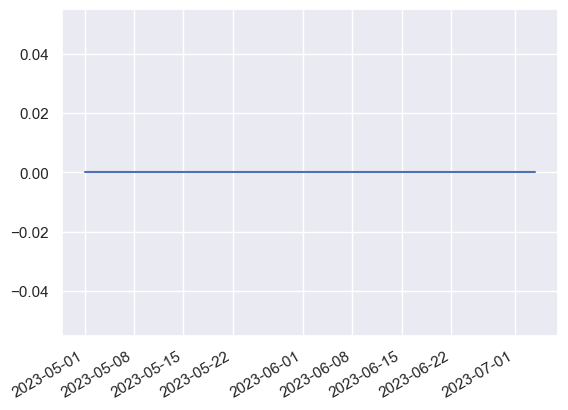

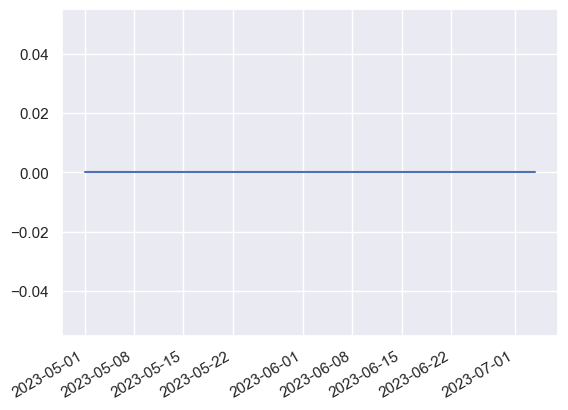

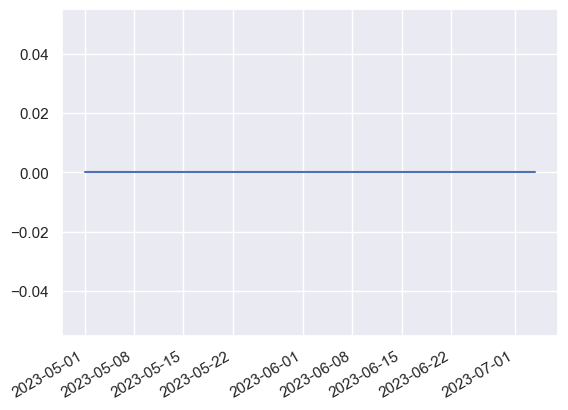

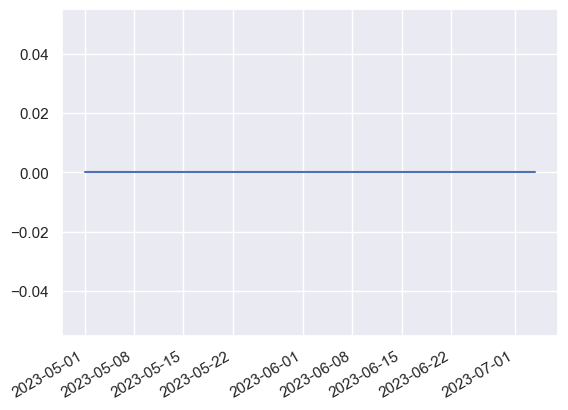

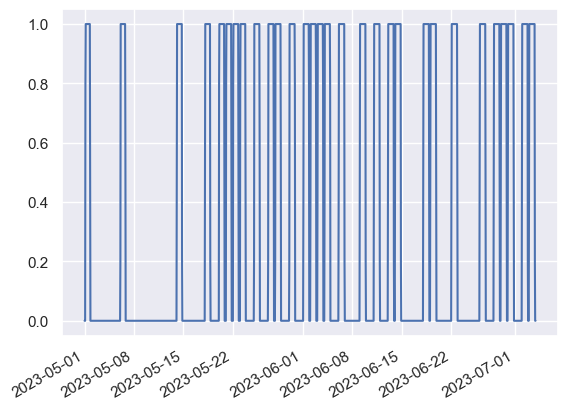

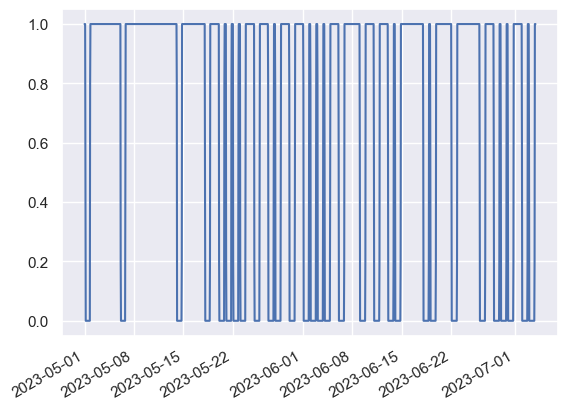

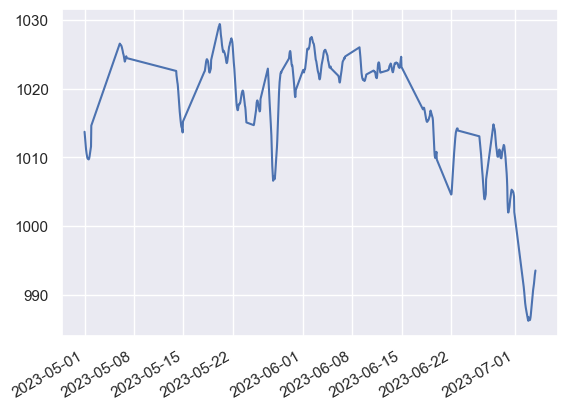

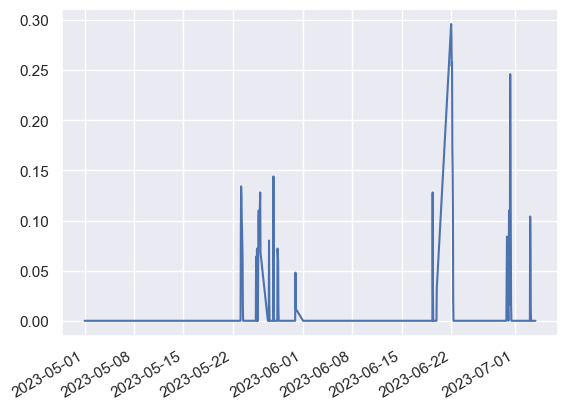

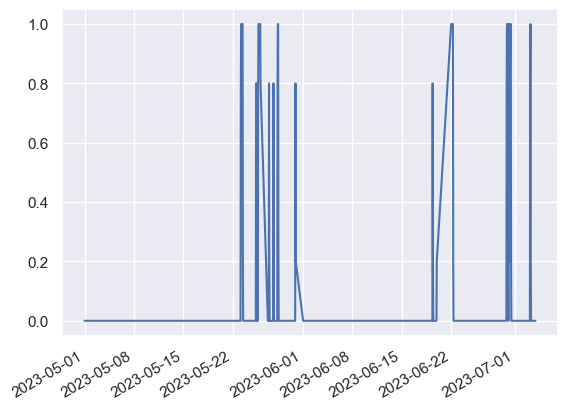

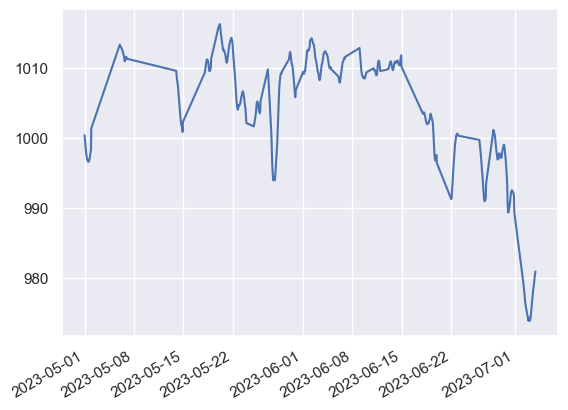

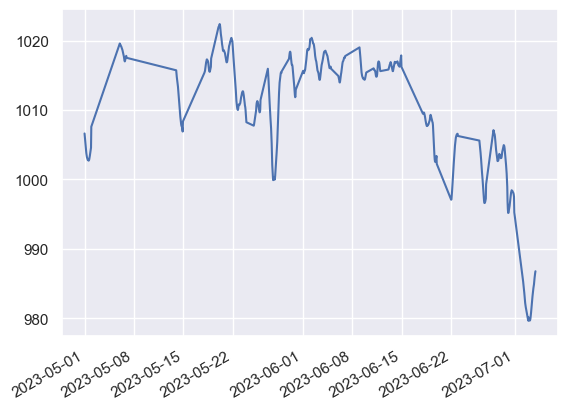

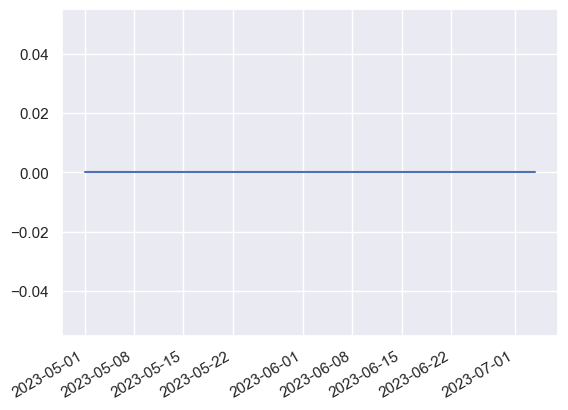

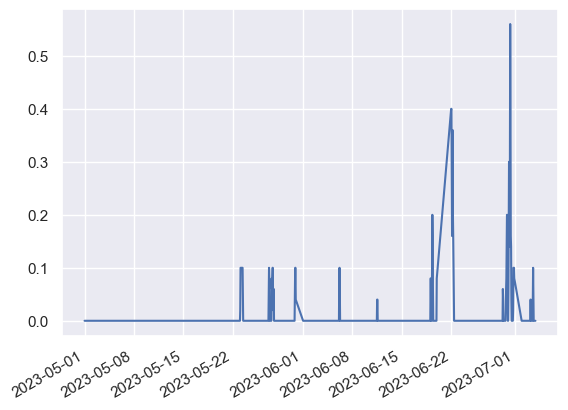

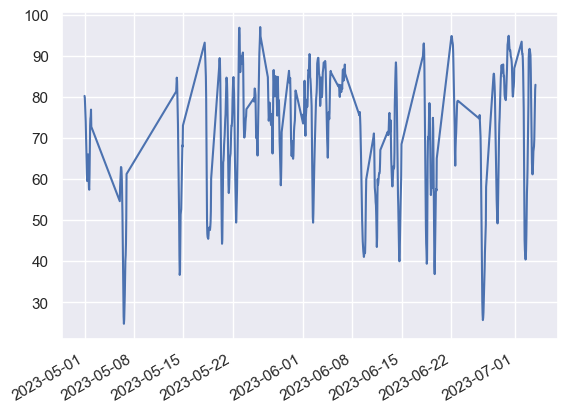

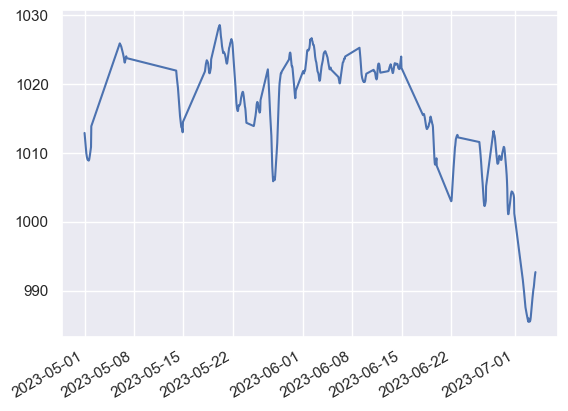

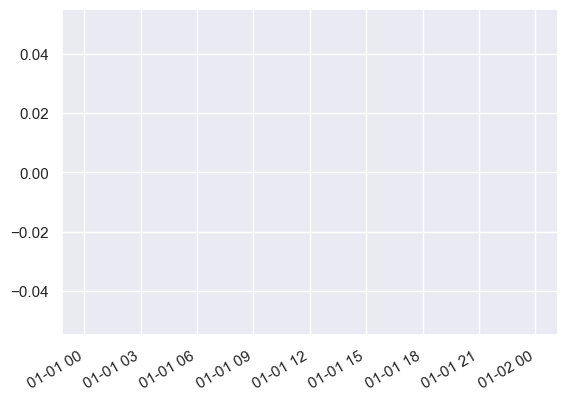

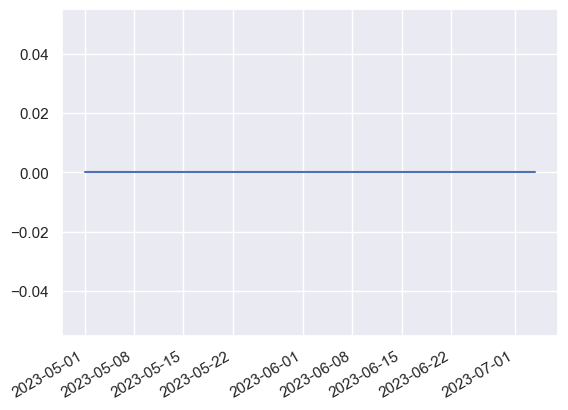

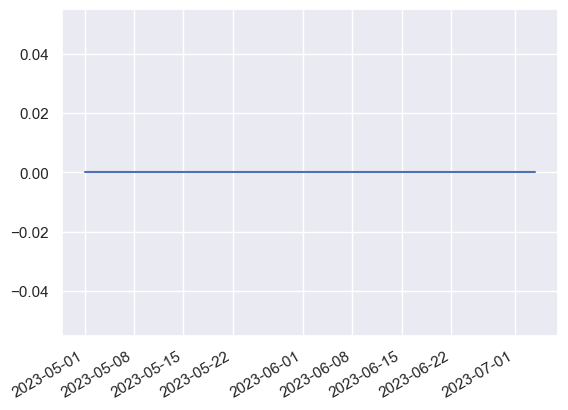

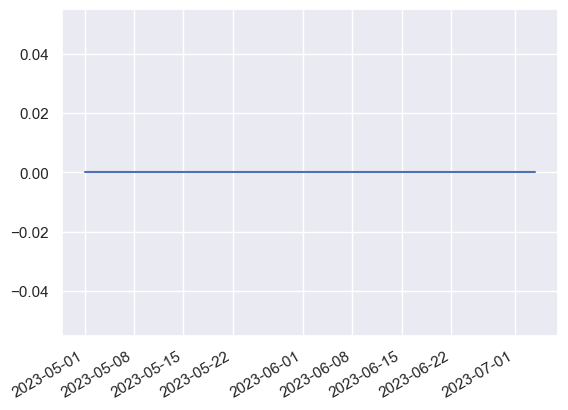

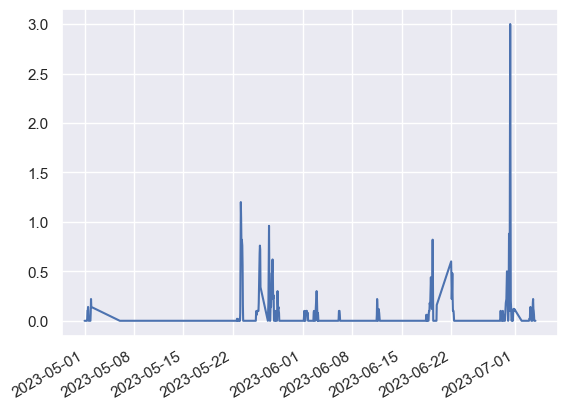

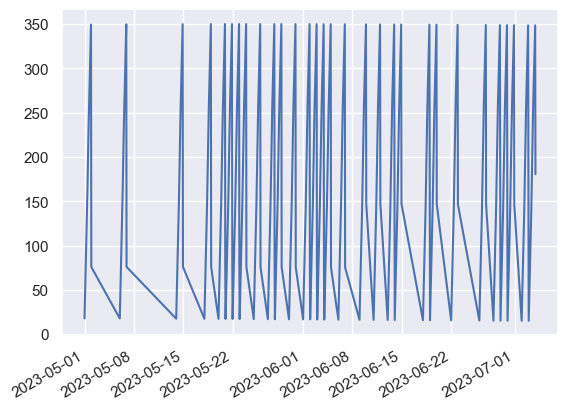

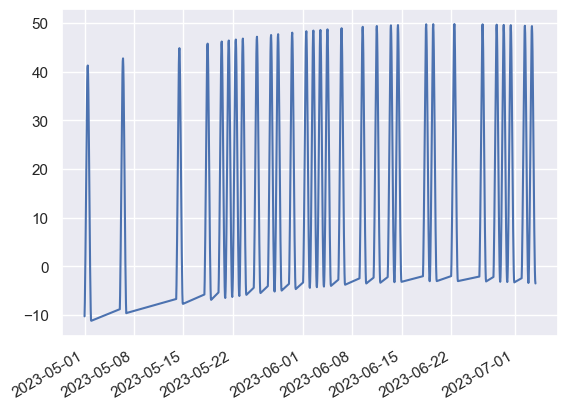

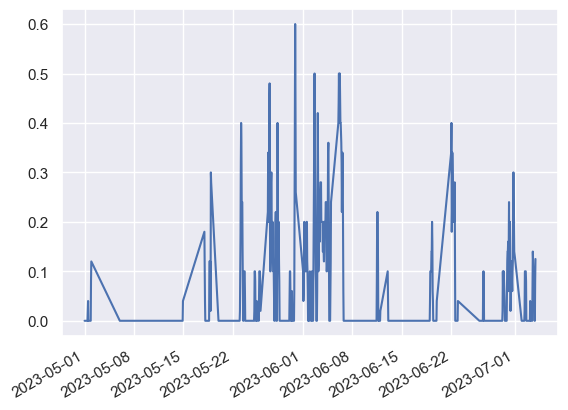

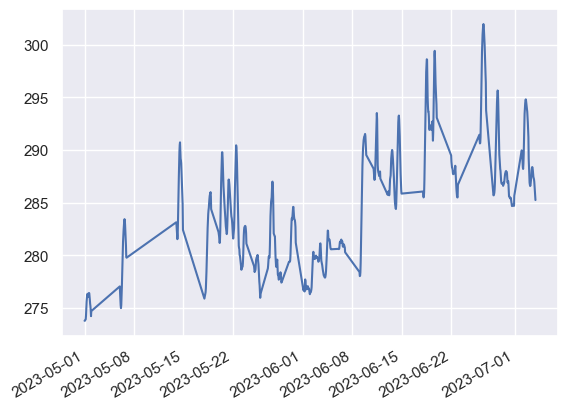

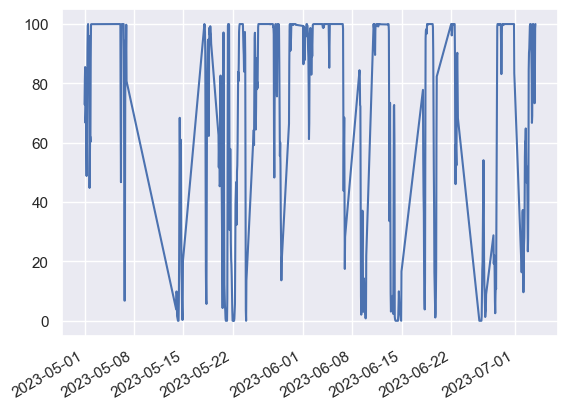

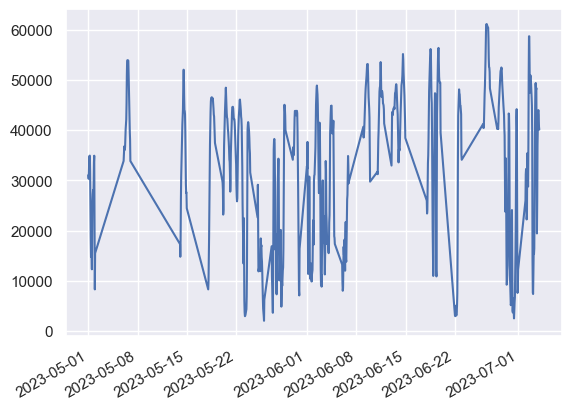

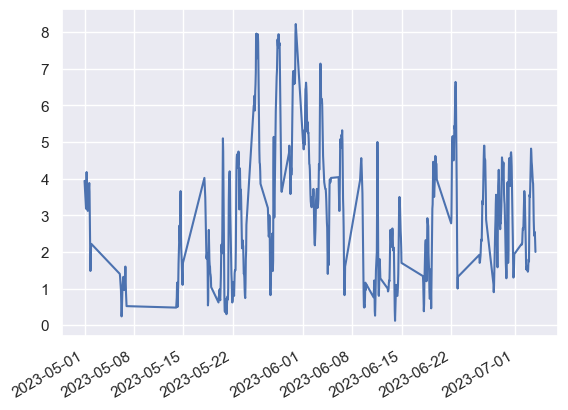

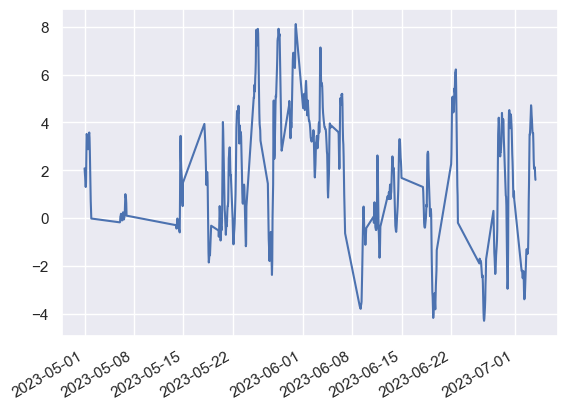

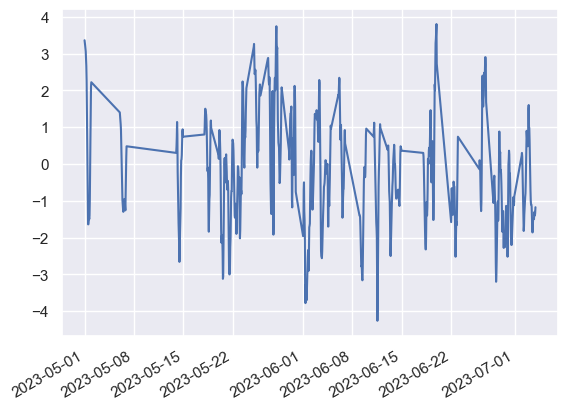

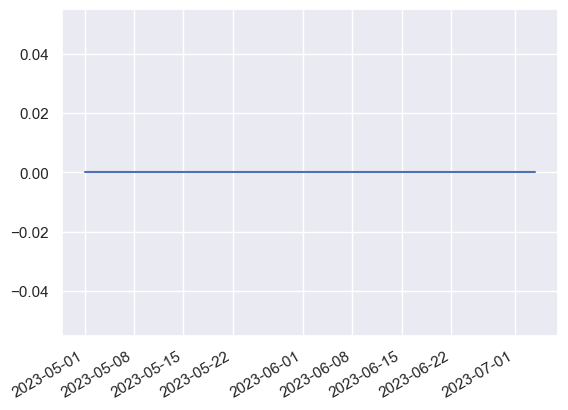

In [14]:
for i in range(len(X_test_estimated_b_clean.columns)-1):
    plt.plot(test_b_dates.iloc[0:720], X_test_estimated_b_clean.iloc[:,[i+1]])
    plt.gcf().autofmt_xdate()
    plt.show()

In [9]:
X_test_estimated_b_clean

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-05-01 00:00:00,4.300000,1.2830,912.299988,0.000000,0.000000,1066.380005,0.0,271.639984,0.000000,0.000000,0.00,0.000000,72.919998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.720032,0.0,0.0,1000.359985,1006.619995,0.0,0.0,80.240005,1012.920044,NaN,0.0,0.0,0.0,0.0,17.848801,-10.257600,0.000,273.799988,72.919998,31033.640625,3.94,2.08,3.360,0.0
1,2023-05-01 01:00:00,4.240000,1.2830,1482.800049,0.000000,0.000000,1067.300049,0.0,271.399994,0.000000,0.000000,0.00,0.000000,80.860001,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.179993,0.0,0.0,999.859985,1006.119995,0.0,0.0,79.680008,1012.420044,NaN,0.0,0.0,0.0,0.0,32.265400,-7.424201,0.000,273.799988,80.860001,30300.400391,3.80,1.90,3.300,0.0
2,2023-05-01 02:00:00,4.140000,1.2826,1860.260010,0.000000,0.000000,1252.880005,0.0,271.000000,0.000000,0.000000,0.00,0.000000,85.500000,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1012.639954,0.0,0.0,999.319946,1005.579956,0.0,0.0,77.599998,1011.880005,NaN,0.0,0.0,0.0,0.0,46.226002,-3.191800,0.000,273.860016,85.500000,31835.917969,3.64,1.72,3.220,0.0
3,2023-05-01 03:00:00,4.000000,1.2824,2280.439941,20059.318359,17.939999,1083.979980,0.0,270.579987,13.780001,24790.761719,3.88,6953.979492,66.760002,7.0,0.0,0.0,0.0,0.0,0.0,0.8,0.4,1012.099976,0.0,0.0,998.779968,1005.039917,0.0,0.0,75.479996,1011.339966,NaN,0.0,0.0,0.0,0.0,59.745995,2.150000,0.000,273.899994,66.760002,34701.101562,3.48,1.44,3.140,0.0
4,2023-05-01 04:00:00,3.920000,1.2816,2156.560059,177616.703125,90.159996,990.880066,0.0,270.380005,52.780006,119818.773438,32.02,64531.917969,68.879997,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1011.599976,0.0,0.0,998.299988,1004.599976,0.0,0.0,73.959999,1010.900024,NaN,0.0,0.0,0.0,0.0,72.988800,8.278200,0.000,273.940002,68.879997,34892.917969,3.32,1.30,3.060,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2023-07-03 19:00:00,8.360001,1.1984,3622.760254,435824.937500,76.139999,1954.219971,0.0,281.600006,31.000000,157857.593750,12.02,48659.917969,84.740005,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,992.119995,0.0,0.0,979.539917,985.400024,0.0,0.0,69.599998,991.279968,NaN,0.0,0.0,0.0,0.0,308.305603,7.509200,0.080,286.979980,85.299995,43567.601562,2.44,2.06,-1.320,0.0
716,2023-07-03 20:00:00,8.559999,1.2012,3283.699951,162042.843750,20.859999,1581.780029,0.0,281.899994,12.520000,78302.171875,2.84,26745.980469,72.580002,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,992.599976,0.0,0.0,979.940063,985.820007,0.0,0.0,73.520004,991.720032,NaN,0.0,0.0,0.0,0.0,321.361176,2.763200,0.000,286.539978,73.320007,43984.000000,2.50,2.14,-1.300,0.0
717,2023-07-03 21:00:00,8.839999,1.2042,2666.020020,30233.859375,1.020000,1680.779907,0.0,282.360016,1.040000,24416.722656,0.00,5130.780273,80.300003,7.0,0.0,0.0,0.0,0.0,0.0,0.2,1.0,992.959961,0.0,0.0,980.299988,986.200012,0.0,0.0,78.599998,992.099976,NaN,0.0,0.0,0.0,0.0,334.737976,-0.778600,0.000,286.020020,80.920006,43003.960938,2.54,2.10,-1.400,0.0
718,2023-07-03 22:00:00,9.020000,1.2062,2166.659912,288.100006,0.000000,1722.379883,0.0,282.680023,0.000000,1882.780029,0.00,0.000000,98.559998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.279968,0.0,0.0,

In [15]:
train_b["pv_measurement"]

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
32843    0.828587
32844   -0.000000
32845   -0.000000
32846   -0.000000
32847   -0.000000
Name: pv_measurement, Length: 32848, dtype: float64

In [17]:
train_b[train_b["pv_measurement"] < 0]

,time,pv_measurement


In [10]:
train_b[train_b.isna().any(axis=1)]

,time,pv_measurement
15930,2020-10-25 23:00:00,NaN
24831,2021-10-31 23:00:00,NaN
29221,2022-05-02 22:00:00,NaN
29222,2022-05-02 23:00:00,NaN


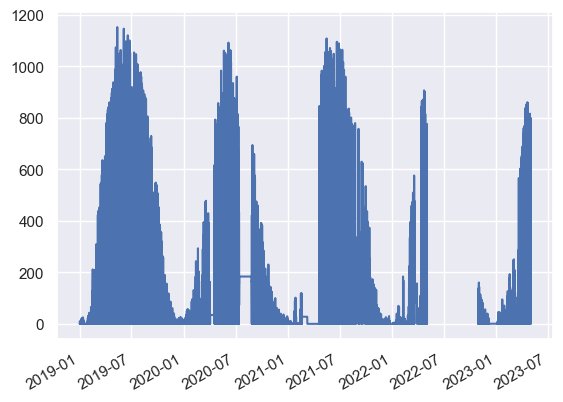

In [9]:
plt.plot(train_b.iloc[:,0], train_b.iloc[:,1])
plt.gcf().autofmt_xdate()
plt.show()